In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy


# Define the top-5-accuracy metric
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [2]:
def resnet18(input_shape, num_classes):
    def conv1(x):
        x = layers.ZeroPadding2D(padding=(3, 3))(x)
        x = layers.Conv2D(64, kernel_size=7, strides=2, padding='valid', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def basic_block(x, filters, strides=1, downsample=False):
        residual = x
        x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            residual = layers.Conv2D(filters, kernel_size=1, strides=strides, use_bias=False)(residual)
            residual = layers.BatchNormalization()(residual)

        x = layers.add([x, residual])
        x = layers.Activation('relu')(x)

        return x

    def stack(x, filters, num_blocks, strides):
        x = basic_block(x, filters, strides, downsample=True)
        for _ in range(1, num_blocks):
            x = basic_block(x, filters)
        return x

    inputs = keras.Input(shape=input_shape)
    x = conv1(inputs)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = stack(x, 64, 2,2)
    x = stack(x, 128, 2, 2)
    x = stack(x, 256, 2, 2)
    x = stack(x, 512, 2, 2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, x)

    return model

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

169001437/169001437 [==============================] - 13s 0us/step


In [4]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [5]:
input_shape = x_train.shape[1:]
num_classes = 100

model = resnet18(input_shape, num_classes)

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy',top_5_accuracy]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [7]:
batch_size = 128
epochs = 30

if datagen is not None:
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test)
    )
else:
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test)
    )




Epoch 1/30
390/390 [==============================] - 28s 71ms/step - loss: 3.8399 - accuracy: 0.1208 - top_5_accuracy: 0.3404 - val_loss: 4.3501 - val_accuracy: 0.0813 - val_top_5_accuracy: 0.2555
Epoch 2/30
390/390 [==============================] - 26s 66ms/step - loss: 3.2742 - accuracy: 0.2038 - top_5_accuracy: 0.4884 - val_loss: 3.4693 - val_accuracy: 0.1816 - val_top_5_accuracy: 0.4429
Epoch 3/30
390/390 [==============================] - 25s 65ms/step - loss: 2.9940 - accuracy: 0.2548 - top_5_accuracy: 0.5622 - val_loss: 3.4104 - val_accuracy: 0.1915 - val_top_5_accuracy: 0.4546
Epoch 4/30
390/390 [==============================] - 25s 64ms/step - loss: 2.7842 - accuracy: 0.2943 - top_5_accuracy: 0.6113 - val_loss: 2.8638 - val_accuracy: 0.2876 - val_top_5_accuracy: 0.5887
Epoch 5/30
390/390 [==============================] - 25s 65ms/step - loss: 2.6167 - accuracy: 0.3271 - top_5_accuracy: 0.6489 - val_loss: 3.0763 - val_accuracy: 0.2724 - val_top_5_accuracy: 0.5632
Epoch 6/30

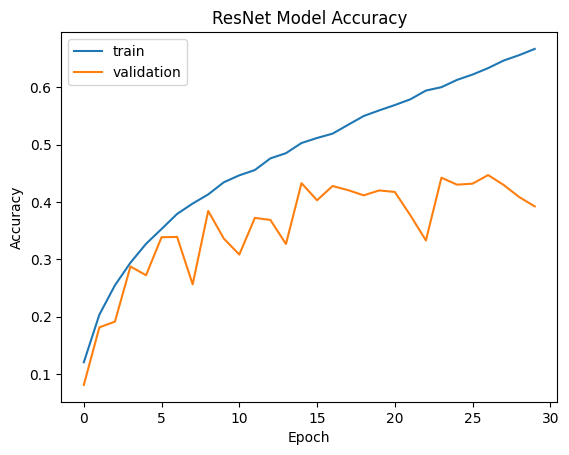

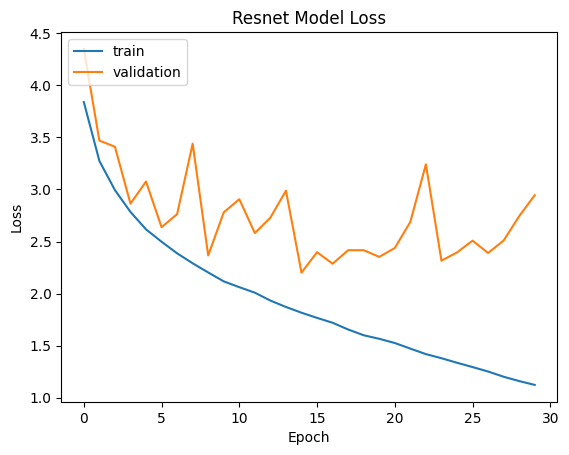

In [8]:
# Plot the accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Resnet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
y_pred = model.predict(x_test)
import numpy as np
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import precision_recall_fscore_support

# Calculate the precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='macro')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

313/313 [==============================] - 2s 4ms/step
Precision: 0.450982440647936
Recall: 0.39230000000000004
F1-score: 0.3856633646801892
